In [2]:
import numpy as np
import cv2 as cv
import tensorflow as tf
import os
import matplotlib.pyplot as plt

# Load images

Right now the 4 class mask is a jpg, and what this u-net model appears to predict is a grayscale $d\times d$ image with pixel values in $\{0,1,2,3\}$. I think that's gross and I would rather predict a boolean $d\times d\times 4$ image.

In [249]:
#load in only one mask

mask_dict = {}
#mask_dict["land_mask"] = cv.imread("new-masks/land_mask.jpg")
mask_dict["marsh_mask"] = cv.imread("new-masks/marsh_mask.jpg")
#mask_dict["pond_mask"] = cv.imread("new-masks/pond_mask.jpg")
#mask_dict["openwater_mask"] = cv.imread("new-masks/openwater_mask.jpg")
four_class_mask = cv.imread("new-masks/4class_mask.jpg")



In [3]:
#trying to use all masks
mask_dict = {}
mask_dict["land_mask"] = cv.imread("new-masks/land_mask.jpg")
mask_dict["marsh_mask"] = cv.imread("new-masks/marsh_mask.jpg")
mask_dict["pond_mask"] = cv.imread("new-masks/pond_mask.jpg")
mask_dict["openwater_mask"] = cv.imread("new-masks/openwater_mask.jpg")







four_class_mask = cv.imread("new-masks/4class_mask.jpg")

In [55]:
#load in the images, do perspective transforms



POINTS1=np.float32([[215,40],[895,65],[305,810],[930,780]])
SIZE = 512
POINTS2 = np.float32([[0,0],[SIZE,0],[0,SIZE],[SIZE,SIZE]])
DIM=(1149,853)

M = cv.getPerspectiveTransform(POINTS1,POINTS2)
#gray_mask = cv.warpPerspective(pre_gray_mask,M,(700,700))


def load_marsh_images(folder):
    images = []
    
    for i in range(1,12):
        img = cv.imread(os.path.join(folder,"Band%d.jpg" % i))
        print("Band%d.jpg" % i)
        if img is not None:
            #convert to black and white
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            #warp so the mask is square
            img = cv.warpPerspective(img,M,(SIZE,SIZE))
            images.append(img)
        

    
    masks = []
    
    classes = len(mask_dict)
    
    for key in mask_dict.keys():
        mask = mask_dict[key]
        print(key)
        #fixing to greyscale seems helpful
        mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
        mask = cv.resize(mask, DIM, interpolation = cv.INTER_AREA)
        mask = cv.warpPerspective(mask,M,(SIZE,SIZE))
        masks.append(mask)
        
        
    images = np.array(images)
    masks = np.array(masks)
    
    #process masks to make them 1-hot
    
    masks = 255.0-masks
    ma = masks.max(axis=(1,2))
    masks = np.transpose(masks,(1,2,0))
    masks = masks/ma
    masks = masks.round(0)
    
    #add masks to get 4 class.
    print(np.array(range(classes)))
    FourClassMask = masks*np.array(range(classes))
    FourClassMask = np.max(FourClassMask,axis=2)
    FourClassMask = np.atleast_3d(FourClassMask)

    
    #masks = np.transpose(masks,(2,0,1))
    
    images = np.transpose(images,(1,2,0))/255.0

    return images,FourClassMask

In [56]:
images,masks = load_marsh_images("train_jpg")

Band1.jpg
Band2.jpg
Band3.jpg
Band4.jpg
Band5.jpg
Band6.jpg
Band7.jpg
Band8.jpg
Band9.jpg
Band10.jpg
Band11.jpg
land_mask
marsh_mask
pond_mask
openwater_mask
[0 1 2 3]


(512, 512, 11) (512, 512, 1)


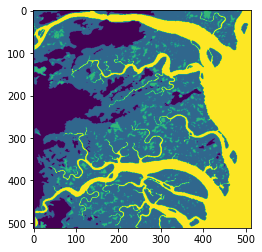

In [57]:
print(images.shape,masks.shape)
plt.imshow(masks)

In [58]:
#check that it's actually a mask.
np.unique(masks)

array([0., 1., 2., 3.])

# Converting to dataset

In [40]:
def get_tensor(image):
    image_tensor = tf.convert_to_tensor(image,dtype =tf.float32)
    
    #a = image_tensor.shape
    #print(list(a))
    #b = [1]
    #b.extend(list(a))
    image_tensor = tf.reshape(image_tensor,b)
    return image_tensor

In [59]:
TEST_SIZE = 256

train_images = get_tensor(images[:TEST_SIZE,:,:])

test_images = get_tensor(images[TEST_SIZE:,:,:])

train_masks = get_tensor(masks[:TEST_SIZE,:,:])

test_masks = get_tensor(masks[TEST_SIZE:,:,:])

"""
train_images = get_tensor(images[:TEST_SIZE,:TEST_SIZE,:])

test_images = get_tensor(images[TEST_SIZE:,TEST_SIZE:,:])

train_masks = get_tensor(masks[:TEST_SIZE,:TEST_SIZE,:])

test_masks = get_tensor(masks[TEST_SIZE:,TEST_SIZE:,:])
"""



train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_masks))

#patch_dataset

test_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_masks))

#not sure why we need this anymore, but it doesn't work without it
train_batches = (
    train_dataset
    .cache()
    #.shuffle(BUFFER_SIZE)
    .batch(1)
    #.repeat()
    #.map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(1)

[256, 512, 11]
[256, 512, 11]
[256, 512, 1]
[256, 512, 1]


In [60]:
# make sure things look right 

test_images.shape,test_masks.shape

(TensorShape([1, 256, 512, 11]), TensorShape([1, 256, 512, 1]))

# Creating the model
I used the same neural network from the tutorial but with a 1x1 convolution to change the number of channels.

In [43]:
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

In [44]:
#tried to use mobilenet with more channels, got issues.

base_model = tf.keras.applications.MobileNetV2(input_shape=[None, None, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [45]:
# try to implement mobilenet (or something like it) myself. 
# for now just try to guess if mask/not mask?
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [46]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[None, None, 11])

    #try to do a 1x1 convolution to get it down to size.
    #reduce_channel = tf.keras.layers.Conv2D(3,1,1,activation="relu")(inputs)
    reduce_channel = tf.keras.layers.Conv2D(3,1,1,activation="relu")(inputs)
  # Downsampling through the model
    #skips = down_stack(inputs)
    skips = down_stack(reduce_channel)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [61]:
#OUTPUT_CLASSES = 4
OUTPUT_CLASSES=4


#if we do 4 classes, I guess we'll need to set the loss to CategoricalCrossentropy. 
#But does pix2pix even work with that? It seemed to not work earlier. 
model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 36          input_2[0][0]                    
__________________________________________________________________________________________________
model (Functional)              [(None, None, None,  1841984     conv2d[0][0]                     
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 5 1476608     model[0][4]                      
____________________________________________________________________________________________

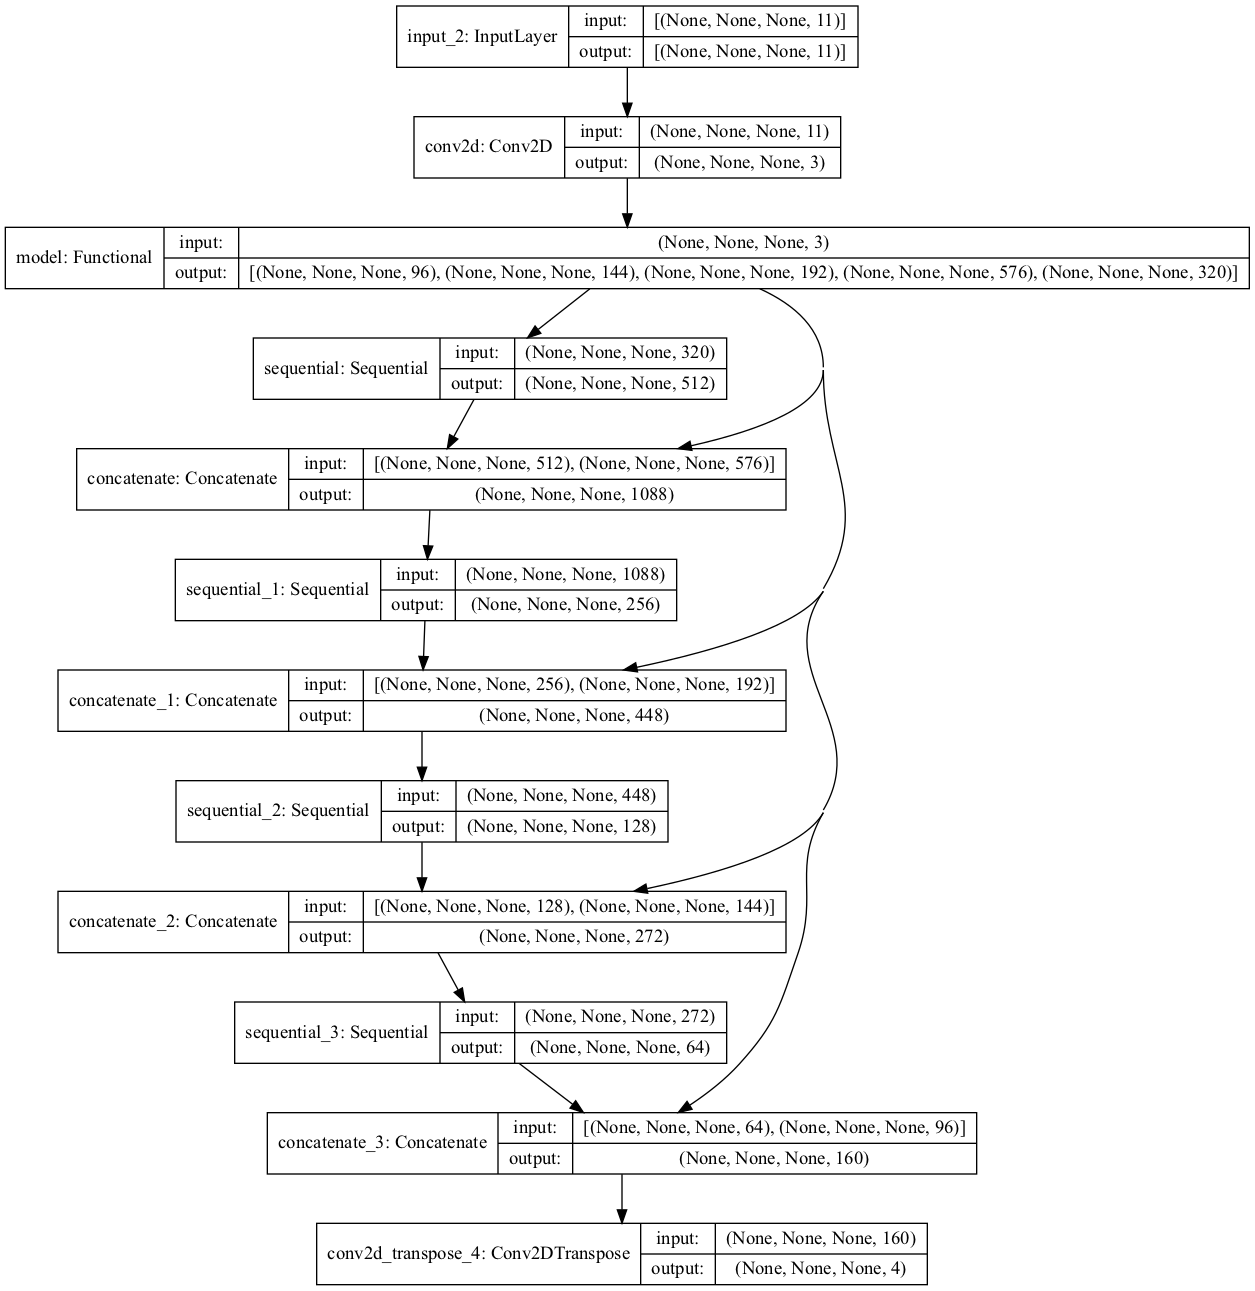

In [122]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Testing the model

Try out the model to check what it predicts before training.

In [63]:
for image,mask in test_dataset.take(1):
    sample_image,sample_mask = image, mask

In [64]:
for image,mask in train_dataset.take(1):
    sample_train_image,sample_train_mask = image, mask

In [65]:
sample_image.shape,sample_mask.shape

(TensorShape([256, 512, 11]), TensorShape([256, 512, 1]))

In [66]:
#to show the 
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

def show_train_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_train_image, sample_train_mask,
             create_mask(model.predict(sample_train_image[tf.newaxis, ...]))])
    
def show_predictions_loaded(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = loaded_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(loaded_model.predict(sample_image[tf.newaxis, ...]))])
    
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i][:,:,:3]))
    plt.axis('off')
  plt.show()

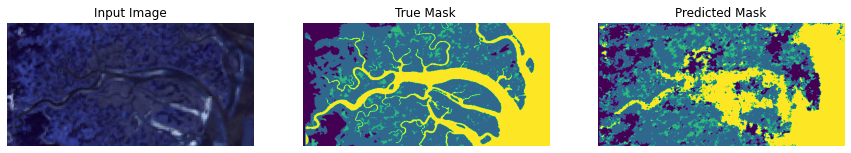

In [73]:
show_predictions()

# Training the model

In [68]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #if epoch % 5==0:
    clear_output(wait=True)
    #show_predictions()
    show_train_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

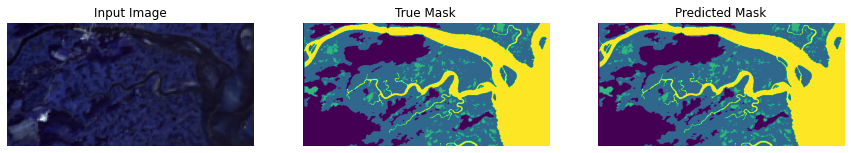


Sample Prediction after epoch 200



In [72]:
EPOCHS = 200
#VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS



model_history = model.fit(train_batches, epochs=EPOCHS,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()]
                         )

# saving/loading

In [74]:
model.save('saved-model-unpatched')

2022-03-02 20:39:20.340544: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved-model-unpatched/assets


/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [ ]:
loaded_model = tf.keras.models.load_model('saved-model-unpatched')

In [ ]:
show_predictions_loaded()